
**Esercizio Lab 1**: Calcolo similarità tra le definizioni create usando cardinalità intersezione


In [1]:
import pandas as pd
definitions_df=pd.read_csv("../data/TLN-definitions-24.csv")

In [2]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#preprocessa una frase tokenizzandola,stemmizando i termini e rimuovendo le stopwords e la punteggiatura,
def preprocess(sentence,stemming=True):
    snow_stm = nltk.stem.SnowballStemmer('english')
    stopword = stopwords.words('english')
    word_tokens = word_tokenize(sentence.lower())
    preprocessed_tokens = [w for w in word_tokens if w.casefold() not in stopword+list(".,;:?!()") ]
    if stemming: preprocessed_tokens = [snow_stm.stem(word) for word in preprocessed_tokens]
    return preprocessed_tokens

#esempio di utilizzo
example_string = "A pen is a tool that is used to write into a paper using ink."
preprocess(example_string)

['pen', 'tool', 'use', 'write', 'paper', 'use', 'ink']

In [3]:
#dato il dataframe di definizioni, e un termine specifico
#ritorrna una lista di liste, contenente tutte le parole prepocessate per ogni definizione
def get_definitions(df,word,stemming=True):
    definitions=[]
    for index, row in df.iterrows():
        if not pd.isna(row[word]):
            definitions.append(preprocess(row[word],stemming))
       
    return definitions

print(get_definitions(definitions_df,"pen"))#stemming
print(get_definitions(definitions_df,"pen",stemming=False))#no stemming

[['object', 'use', 'write', 'paper', 'fill', 'ink'], ['object', 'use', 'write', 'peper'], ['pen', 'tool', 'use', 'write', 'paper', 'use', 'ink'], ['pen', 'object', 'use', 'write', 'ink'], ['object', 'use', 'write', 'paper', 'usual', 'tool', 'permit', 'spread', 'ink', 'paper', 'follow', 'direct', 'hand', 'util', 'stylograph', 'case', 'requir', 'manual', 'ink', 'ball', 'pen', 'case', 'ink', 'flow', 'bodi', 'pen', 'ball', 'roll', 'paper'], ['stick', 'write', 'ink', 'someword', 'sketch', 'draw'], ['pen', 'object', 'use', 'write', 'paper', 'ink'], ['pen', 'tool', 'use', 'write', 'text'], ['pen', 'write', 'tool', 'use', 'ink'], ['pen', 'tool', 'write', 'paper', 'usual', 'black', 'blue', 'red'], ['object', 'use', 'write', 'sheet', 'paper'], ['object', 'use', 'write', 'could', 'differ', 'colour', 'shape'], ['pen', 'tool', 'use', 'write', 'text'], ['pen', 'cylindr', 'object', 'use', 'repres', 'generic', 'concept', 'piec', 'paper'], ['pen', 'object', 'tool', 'use', 'peopl', 'primarili', 'write',

In [4]:
#date due liste di token stemmizzati di una definizione
#calcola la similarità come intersezione di parole in comune normalizzato sulla lunghezza della lista più corta
def similarity(def1,def2):
    common_word=set()
    for word in def1:
        if word in def2:
            common_word.add(word)
    if len(common_word)>0:
        return len(common_word)/min(len(def1),len(def2))
    else:
        return 0

In [5]:
from collections import Counter
#calcola la similarità tra ogni coppia di definizione e ne ritorna la media
def pairwise_similarity(def_list):
    similarities=[]
    for i in range(0,len(def_list)):
        for j in range(i,len(def_list)):
            similarities.append(similarity(def_list[i],def_list[j]))
    return sum(similarities)/len(similarities)

#ottiene la lista delle k-parole più frequenti da una lisa di definizioni
def top_k_words(def_list, k):
    counts = Counter([w for d in def_list for w in d])
    return  [el[0] for el in counts.most_common(k)]

#calcola la media delle similirità tra le singole definizioni e le top-k parole più frequenti
def k_similarity(def_list,k):
    similarities=[]
    #rappresentazione del "concetto"
    def_set=top_k_words(def_list,k)
    for d in def_list:
        similarities.append(similarity(def_set,d))
    return sum(similarities)/len(similarities)

In [6]:
#realizza una visualizzazione grafica delle similarità per i 4 termini in esame
import matplotlib.pyplot as plt
def create_table(data):
    fig, axs = plt.subplots(2, 2)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    for (word, val), ax in zip(data.items(), axs.flatten()):
        ax.text(0.5, 0.5, f"{word}\nSimilarity: {val}", fontsize=18, ha='center', va='center')
        ax.axis('off')

    for i, row_label in enumerate(["Generic", "Specific"]):
        axs[i, 0].text(-0.2, 0.5, row_label, fontsize=14, ha='center', va='center', rotation=90)

    for j, col_label in enumerate(["Abstract", "Concrete"]):
        axs[1, j].text(0.5, 2.5, col_label, fontsize=14, ha='center', va='center')
    plt.show()

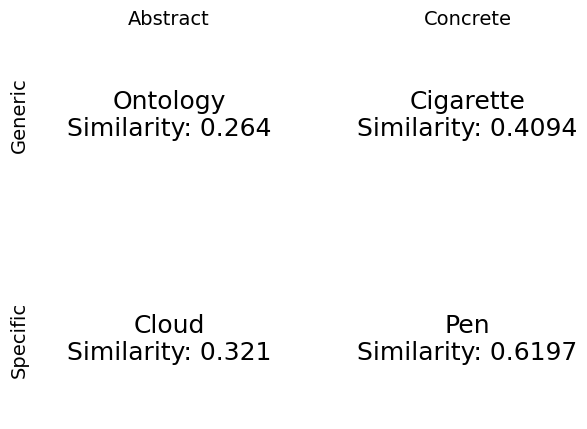

In [7]:
#Pairwise similarity 
def_pen=get_definitions(definitions_df,"pen")
def_cigarette=get_definitions(definitions_df,"cigarette")
def_cloud=get_definitions(definitions_df,"cloud")
def_ontology=get_definitions(definitions_df,"ontology")

data={
    "Ontology": round(pairwise_similarity(def_ontology),4),
    "Cigarette": round(pairwise_similarity(def_cigarette),4),
    "Cloud": round(pairwise_similarity(def_cloud),4),
    "Pen": round(pairwise_similarity(def_pen),4),
}
create_table(data)

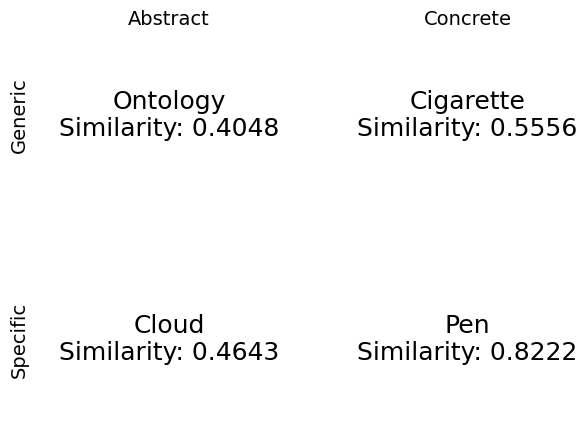

In [8]:
#K similarity 
data2={
    "Ontology": round(k_similarity(def_ontology,3),4),
    "Cigarette": round(k_similarity(def_cigarette,3),4),
    "Cloud": round(k_similarity(def_cloud,3),4),
    "Pen": round(k_similarity(def_pen,3),4),
}
create_table(data2)

----

**Esercizio Lab 2** : Ricerca Onomasiologica usando WordNet

In [9]:
from nltk.corpus import wordnet as wn

In [10]:
#aggiunge una definizione al dizionario, calcolando la similarità 
def  add_definitions_wn(synset,dict,topK):
    snow_stm = nltk.stem.SnowballStemmer('english')
    topK_stemmed = [snow_stm.stem(word) for word in topK]
    definition = preprocess(synset.definition())
    sim_val = similarity(topK_stemmed, definition)
    dict[synset.name()] = (definition, sim_val)
    return dict

#funzione ricorsiva che aggiunge le definizioni di tutti gli iponimi di un synset fino ad un certo livello
def explore_hyponyms(synset,dict,topK,max_lvl,lvl): 
    if lvl>max_lvl: 
        return
    hyponyms = synset.hyponyms()
    for hyponym in hyponyms:
        dict=add_definitions_wn(hyponym,dict,topK)
        explore_hyponyms(hyponym,dict,topK,max_lvl,lvl+1)

#dato un insieme di parole, ne esplora gli iponimi e le loro definizioni calcolando la similarità
#ritorna un dizionario word: (definition,similarity) 
def get_definitions_wn(topK,max_lvl):
    dict={}
    for word in topK:
        synsets = wn.synsets(word,pos = wn.NOUN)#prendo solo i nomi per la ricerca (vengono comunque utilizzati per la similarità)
        for synset in synsets:
            dict=add_definitions_wn(synset,dict,topK)
            explore_hyponyms(synset,dict,topK,max_lvl=max_lvl,lvl=0)
    return dict

def pretty_print(wn_definitions):
    for key in sorted(wn_definitions,key=lambda x: wn_definitions[x][1],reverse=True)[:5]:
        print(round(wn_definitions[key][1],2),"-",key,": ",wn_definitions[key][0])
    

for word in ["pen","cigarette","cloud","ontology"]:
    def_list=get_definitions(definitions_df,word,stemming=False)
    topK=top_k_words(def_list,4)
    #topK.remove(word)
    print("#",word,"-----",topK)
    wn_definitions=get_definitions_wn(topK,3)
    pretty_print(wn_definitions)

# pen ----- ['used', 'pen', 'write', 'object']
0.5 - felt-tip_pen.n.01 :  ['pen', 'write', 'tip', 'made', 'felt', 'trade', 'name', 'magic', 'marker']
0.5 - sharpie.n.03 :  ['pen', 'indel', 'ink', 'write', 'surfac']
0.5 - cow_pen.n.01 :  ['pen', 'cattl']
0.5 - fold.n.06 :  ['pen', 'sheep']
0.5 - sty.n.02 :  ['pen', 'swine']
# cigarette ----- ['tobacco', 'cigarette', 'paper', 'object']
0.75 - cigarillo.n.01 :  ['small', 'cigar', 'cigarett', 'wrap', 'tobacco', 'instead', 'paper']
0.75 - cigarette_paper.n.01 :  ['strong', 'tissu', 'paper', 'burn', 'even', 'suffici', 'porous', 'control', 'burn', 'tobacco', 'cigarett']
0.5 - cigarette.n.01 :  ['fine', 'ground', 'tobacco', 'wrap', 'paper', 'smoke']
0.5 - turkish_tobacco.n.01 :  ['dark', 'aromat', 'tobacco', 'eastern', 'europ', 'use', 'cigarett']
0.5 - revenue_stamp.n.01 :  ['small', 'piec', 'adhes', 'paper', 'put', 'object', 'show', 'govern', 'tax', 'paid']
# cloud ----- ['cloud', 'water', 'different', 'atmosphere']
0.5 - contrail.n.01 :  ['a